# Load data

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from utils import get_train_data

2022-02-24 17:51:58.099394: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
if sys.platform == 'linux':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print('GPU detected')
        
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

GPU detected


2022-02-24 17:52:00.241951: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-02-24 17:52:01.303398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 17:52:01.304295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-02-24 17:52:01.304365: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-02-24 17:52:01.308196: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-02-24 17:52:01.311748: I tensorflow/stream_executor/pla

In [3]:
X_train, y_train = get_train_data(skip_midpoints=True, all_labels=True)

id1_hook_2|reversed: False|data shape: (792, 34)
--------------------
id3_hook_1|reversed: False|data shape: (1461, 34)
--------------------
id3_hook_2|reversed: False|data shape: (1297, 34)
--------------------
id4_hook_1|reversed: False|data shape: (1054, 34)
--------------------
id4_hook_2|reversed: False|data shape: (1059, 34)
--------------------
id1_hook_1|reversed: False|data shape: (858, 34)
--------------------
id2_hook_1|reversed: False|data shape: (1013, 34)
--------------------
id0_hook_2|reversed: False|data shape: (1051, 34)
--------------------
id0_hook_1|reversed: False|data shape: (1100, 34)
--------------------
id2_hook_2|reversed: False|data shape: (1041, 34)
--------------------
id3_jab_2|reversed: False|data shape: (1164, 34)
--------------------
id4_jab_1|reversed: False|data shape: (911, 34)
--------------------
id2_jab_1|reversed: False|data shape: (1032, 34)
--------------------
id0_jab_1|reversed: False|data shape: (952, 34)
--------------------
id0_jab_2|reve

In [4]:
X_train.shape, y_train.shape

((31074, 34), (31074,))

In [5]:
def compute_vector_angle(p0, p1, p2):
    # vector p0 - p1
    v1 = p0 - p1
    
    # vector p0 - p2
    v2 = p2 - p1
    
    v1_length = np.sqrt(v1[0] ** 2 + v1[1] ** 2)
    v2_length = np.sqrt(v2[0] ** 2 + v2[1] ** 2)
    
    cos = (v1[0] * v2[0] + v1[1] * v2[1]) / (v1_length * v2_length)
    
    if cos < -1:
        cos = -1
        
    if cos > 1:
        cos = 1

    return np.arccos(cos)


assert np.round(compute_vector_angle(np.array([2, 6]), np.array([0, 0]), np.array([8, 4])), 2) == 0.79


# nose            0,1
# left_eye        2,3
# right_eye       4,5
# left_ear        6,7
# right_ear       8,9
# left_shoulder   10,11
# right_shoulder  12,13
# left_elbow      14,15
# right_elbow     16,17
# left_wrist      18,19
# right_wrist     20,21

def add_angles(keypoints):
    return np.append(
        keypoints,
        [
            compute_vector_angle(keypoints[10:12], keypoints[14:16], keypoints[18:20]), # angle between left shoulder and wrist in radians
            compute_vector_angle(keypoints[12:14], keypoints[16:18], keypoints[20:22]), # angle between right shoulder and wrist in radians
        ])

In [6]:
X_train = np.apply_along_axis(add_angles, 1, X_train)
X_train.shape

(31074, 36)

In [7]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16,
    'angle': 17,
}

In [8]:
def format_feature_names(names):
    """"Form list of feature names

    Params:
        names - list of KEYPOINT_DICT keys
        ndims - number of dimensions (x, y, score)
        skip_midpoints - add or omit midpoint coords (x, y, score)

    Returns:
        list of feature names
    """
    feature_names = []
    for name in names:
        if 'angle' in name:
            feature_names.append(name+'-left-arm')
            feature_names.append(name+'-right-arm')
        else:
            feature_names.append(name+'-x')
            feature_names.append(name+'-y')

    return feature_names

In [9]:
feature_names = format_feature_names(list(KEYPOINT_DICT.keys()))

In [10]:
df = pd.DataFrame(data=X_train, columns=feature_names)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,31074.0,-0.220691,0.028890,-0.407440,-0.237477,-0.218163,-0.202571,0.361919
nose-y,31074.0,-0.141959,0.060751,-0.467713,-0.185971,-0.143881,-0.103798,0.475557
left_eye-x,31074.0,-0.232318,0.029956,-0.340721,-0.249898,-0.229959,-0.213657,0.359797
left_eye-y,31074.0,-0.139179,0.064997,-0.480470,-0.186218,-0.144911,-0.101038,0.477576
right_eye-x,31074.0,-0.234061,0.030328,-0.344901,-0.252474,-0.230849,-0.215103,0.359336
right_eye-y,31074.0,-0.133812,0.060529,-0.473905,-0.176613,-0.133870,-0.094512,0.475477
left_ear-x,31074.0,-0.233495,0.029593,-0.444675,-0.252486,-0.232580,-0.214265,0.366997
left_ear-y,31074.0,-0.095097,0.068961,-0.451503,-0.144561,-0.108980,-0.052620,0.474723
right_ear-x,31074.0,-0.238615,0.030643,-0.346178,-0.258294,-0.236333,-0.218362,0.363357
right_ear-y,31074.0,-0.080467,0.056187,-0.465192,-0.115846,-0.075599,-0.042123,0.473494


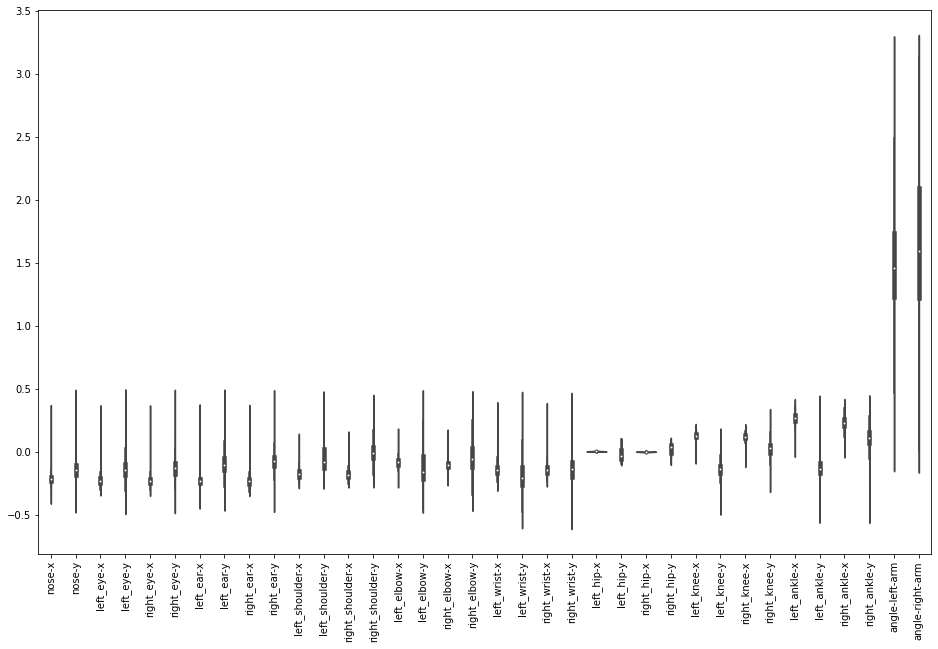

In [11]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [12]:
time_steps = 30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps
N_train

1035

In [13]:
X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 36)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_train.shape

(1035, 30, 36)

## LSTM

In [14]:
y_train = K.utils.to_categorical(y_train, num_classes=13)
X_train = tf.constant(X_train, dtype=tf.float32)

2022-02-24 17:52:32.530445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 17:52:32.561732: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2295660000 Hz
2022-02-24 17:52:32.562690: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6931280 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-24 17:52:32.562742: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-02-24 17:52:32.727647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-0

In [15]:
assert X_train.dtype == tf.float32 # che check that X_train is float32 (float64 causes problems after converting to tflite)

In [22]:
def model_builder(hp):
    # Hyperparams
    hp_ru1 = hp.Int('recurrent_units1', min_value=16, max_value=128, step=8)
    # hp_ru2 = hp.Int('recurrent_units2', min_value=16, max_value=128, step=8)

    hp_du1 = hp.Int('units1', min_value=16, max_value=128, step=8)
    hp_du2 = hp.Int('units2', min_value=16, max_value=128, step=8)

    hp_reg1 = hp.Float('dense_reg1', min_value=1e-4, max_value=1e-2)
    hp_reg2 = hp.Float('dense_reg2', min_value=1e-4, max_value=1e-2)
    
    hp_dp1 = hp.Float('rec_dropout1', min_value=0., max_value=0.4)
    # hp_dp2 = hp.Float('rec_dropout2', min_value=0., max_value=0.4)
        
    hp_dl_dp1 = hp.Float('dropout1', min_value=0., max_value=0.4)
    hp_dl_dp2 = hp.Float('dropout2', min_value=0., max_value=0.4)

    hp_rec_dp1 = hp.Float('rec_dropout1', min_value=0., max_value=0.4)
    # hp_rec_dp2 = hp.Float('rec_dropout2', min_value=0., max_value=0.4)
        
    hp_kernel_reg1 = hp.Float('kernel_reg1', min_value=1e-5, max_value=1e-3, sampling='log')
    # hp_kernel_reg2 = hp.Float('kernel_reg2', min_value=1e-5, max_value=1e-3, sampling='log')

    hp_recur_reg1 = hp.Float('recur_reg1', min_value=1e-5, max_value=1e-3, sampling='log')
    # hp_recur_reg2 = hp.Float('recur_reg2', min_value=1e-5, max_value=1e-3, sampling='log')

    hp_act_reg1 = hp.Float('act_reg1', min_value=1e-5, max_value=1e-3, sampling='log')
    # hp_act_reg2 = hp.Float('act_reg2', min_value=1e-5, max_value=1e-3, sampling='log')

    # hp_add_another_rec_layer = hp.Boolean('add_another_gru_layer')
 
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    layers = []
    
    # Model
    kernel_reg1 = K.regularizers.l2(hp_kernel_reg1)
    # kernel_reg2 = K.regularizers.l2(hp_kernel_reg2)
    
    recurrent_reg1 = K.regularizers.l2(hp_recur_reg1)
    # recurrent_reg2 = K.regularizers.l2(hp_recur_reg2)
        
    act_reg1 = K.regularizers.l2(hp_act_reg1)
    # act_reg2 = K.regularizers.l2(hp_act_reg2)

    model = K.Sequential()
    model.add(K.layers.BatchNormalization(axis=1))
    model.add(K.layers.LSTM(hp_ru1,
                             # stateful=True, # mutable states not supported in tflite
                             return_sequences=True,
                             kernel_regularizer=kernel_reg1,
                             recurrent_regularizer=recurrent_reg1,
                             activity_regularizer=act_reg1,
                             dropout=hp_dp1,
                             recurrent_dropout=hp_rec_dp1
                           ))

    # with hp.conditional_scope('add_another_gru_layer', [True]):
    #     model.add(K.layers.LSTM(hp_ru2,
    #                          # stateful=True, # mutable states not supported in tflite 
    #                          return_sequences=True,
    #                          kernel_regularizer=kernel_reg2,
    #                          recurrent_regularizer=recurrent_reg2,
    #                          activity_regularizer=act_reg2,
    #                          dropout=hp_dp2,
    #                          recurrent_dropout=hp_rec_dp2
    #                        ))
        
    model.add(K.layers.Dense(hp_du1, activation='relu',
                            kernel_regularizer=K.regularizers.l2(hp_reg1)))
    model.add(K.layers.Dropout(hp_dl_dp1))
    model.add(K.layers.Dense(hp_du2, activation='relu',
                            kernel_regularizer=K.regularizers.l2(hp_reg2)))
    model.add(K.layers.Dropout(hp_dl_dp2))
    model.add(K.layers.Dense(13, activation='sigmoid'))

    model.compile(optimizer=K.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [23]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=32,
                     directory='kt_dir',
                     project_name='punch_dl_kt_lstm')

stop_early = K.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, batch_size=4, validation_split=0.33, epochs=32, shuffle=False, callbacks=[stop_early])

Trial 84 Complete [00h 01m 57s]
val_accuracy: 0.4840155839920044

Best val_accuracy So Far: 0.555165708065033
Total elapsed time: 01h 26m 08s

Search: Running Trial #85

Hyperparameter    |Value             |Best Value So Far 
recurrent_units1  |48                |72                
units1            |72                |64                
units2            |88                |32                
dense_reg1        |0.0071922         |0.0051014         
dense_reg2        |0.0090064         |0.0054107         
rec_dropout1      |0.28345           |0.11214           
dropout1          |0.20486           |0.045739          
dropout2          |0.2366            |0.16303           
kernel_reg1       |0.00025319        |1.1719e-05        
recur_reg1        |1.1755e-05        |0.00015578        
act_reg1          |0.00016216        |0.00077771        
learning_rate     |0.0066076         |0.0011769         
tuner/epochs      |32                |32                
tuner/initial_e...|11           

KeyboardInterrupt: 

In [24]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'recurrent_units1': 72,
 'units1': 64,
 'units2': 32,
 'dense_reg1': 0.005101448961916395,
 'dense_reg2': 0.0054106690276460095,
 'rec_dropout1': 0.1121391838102067,
 'dropout1': 0.045739222099927625,
 'dropout2': 0.16303392210548237,
 'kernel_reg1': 1.1719128865860812e-05,
 'recur_reg1': 0.00015577695321475487,
 'act_reg1': 0.0007777133391633722,
 'learning_rate': 0.0011769061574142916,
 'tuner/epochs': 32,
 'tuner/initial_epoch': 11,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': 'c55164c84b1d0ffa17c39e4065d3a0bd'}

In [25]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=4,
                    validation_split=0.33, 
                    epochs=48,
                    shuffle=False,
                    callbacks=[
                        K.callbacks.ReduceLROnPlateau(),
                        K.callbacks.ModelCheckpoint(filepath='checkpoints/lstm', save_weights_only=True),
                        K.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
                    ])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/48
174/174 [==============================] - 19s 108ms/step - loss: 2.4777 - accuracy: 0.4076 - val_loss: 2.5383 - val_accuracy: 0.4817
Epoch 2/48
174/174 [==============================] - 19s 107ms/step - loss: 2.0449 - accuracy: 0.4400 - val_loss: 2.4925 - val_accuracy: 0.4817
Epoch 3/48
174/174 [==============================] - 19s 110ms/step - loss: 1.9562 - accuracy: 0.4400 - val_loss: 2.6570 - val_accuracy: 0.4817
Epoch 4/48
174/174 [==============================] - 19s 109ms/step - loss: 1.8551 - accuracy: 0.4400 - val_loss: 2.6694 - val_accuracy: 0.4817
Epoch 5/48
174/174 [==============================] - 19s 108ms/step - loss: 1.8024 - accuracy: 0.4454 - val_loss: 2.7118 - val_accuracy: 0.4817
Epoch 6/48
174/174 [==============================] - 19s 108ms/step - loss: 1.7707 - accuracy: 0.4623 - val_loss: 2.6049 - val_accuracy: 0.4827
Epoch 7/48
174/174 [==============================] - 18s 105ms/step - loss: 1.7133 - accuracy: 0.4689 - val_loss: 2.5333 - val_ac

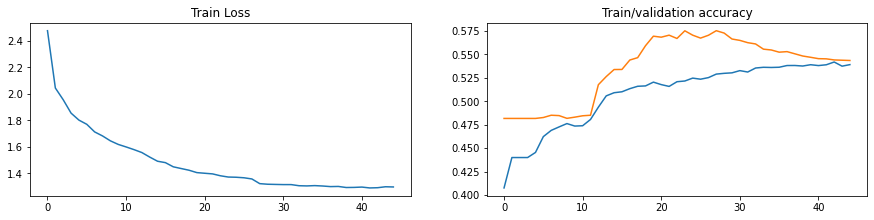

In [26]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.savefig('imgs/train_val_acc.png', bbox_inches='tight')

# Conclusion 

* need more data to avoid overfitting
* need simpler architecture (2 recurrent layers is too much)
* add dropout layers

# Try

* 2d convolutions
* attention mechanism

# Save model

In [ ]:
model.save('./models/lstm__with_angles.h5')